In [1]:
# import Libraries
import matplotlib
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import mlxtend as mlx
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, r2_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from IPython.core.interactiveshell import InteractiveShell
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection

In [2]:
# show current work dir
%pwd

'/Users/jishengx/Documents/mie1624/pre'

In [3]:
# double check dataset
import os
assert os.path.getsize("Real_estate.csv") == 21968

In [4]:
# csv to dataframe
# Source: https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction
real_estate = pd.read_csv('Real_estate.csv')
real_estate = real_estate.sample(frac=1, replace=False, random_state=90)

In [5]:
# calculate data size
test_data_size = int(real_estate.shape[0]*0.1)
train_data_size = real_estate.shape[0] - test_data_size
# divide dataset
test_data = real_estate[:test_data_size]
train_data = real_estate[test_data_size:]
print(train_data.shape)
print(test_data.shape)

(373, 8)
(41, 8)


<AxesSubplot:>

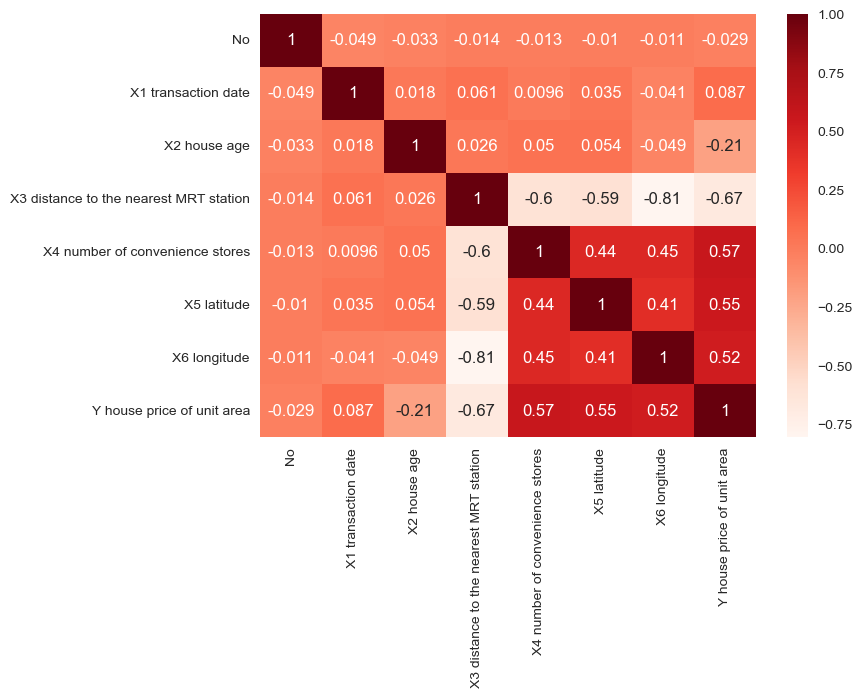

In [6]:
# Heatmap showing the correlations
sns.heatmap(real_estate.corr(), annot=True,cmap='Reds')

Based on the headmap, location ('latitude' & 'longitude'), 'number of convenience stores', and 'distance to the nearest MRT station' are the most relevant features to 'house price of unit area'. 

In [7]:
# Separate X and Y
X_train= train_data.drop(['Y house price of unit area','No'], axis=1)
y_train=train_data['Y house price of unit area']
X_test= test_data.drop(['Y house price of unit area','No'], axis=1)
y_test= test_data['Y house price of unit area']

#Scaling the data
scaler = StandardScaler()
train_std = scaler.fit_transform(X_train)
test_std = scaler.transform(X_test)

# Convert dataframe to numpy array
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

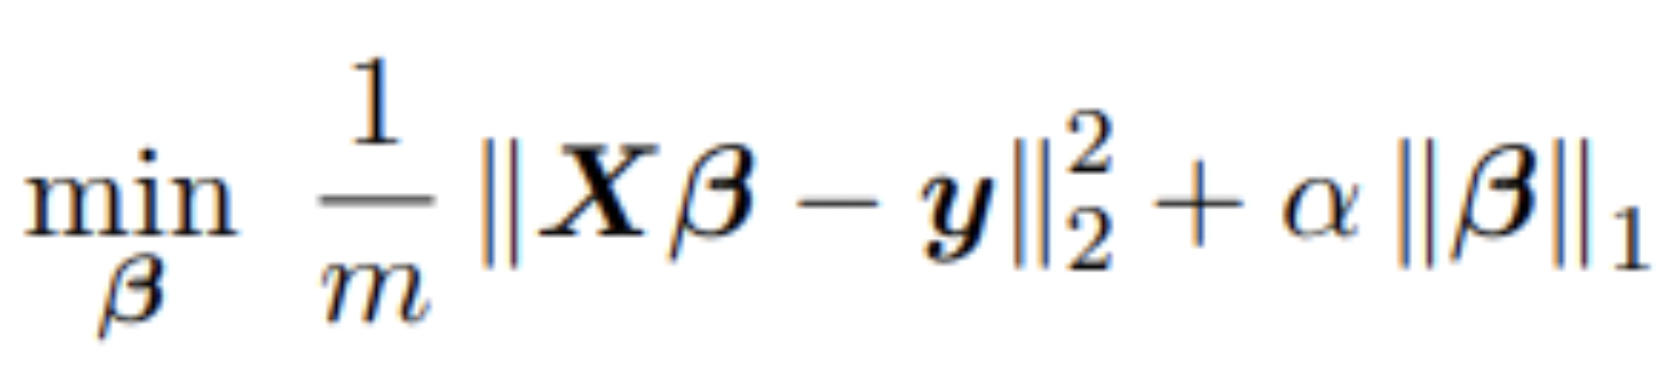

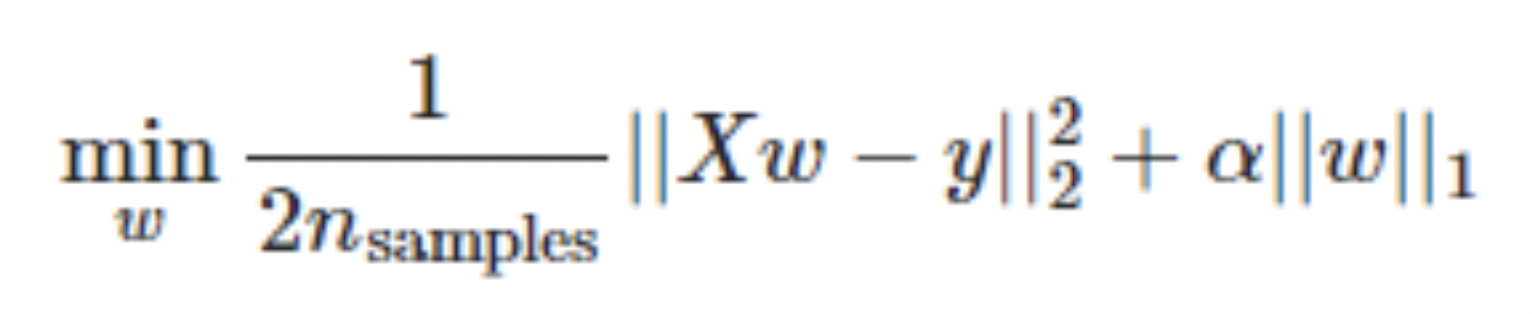

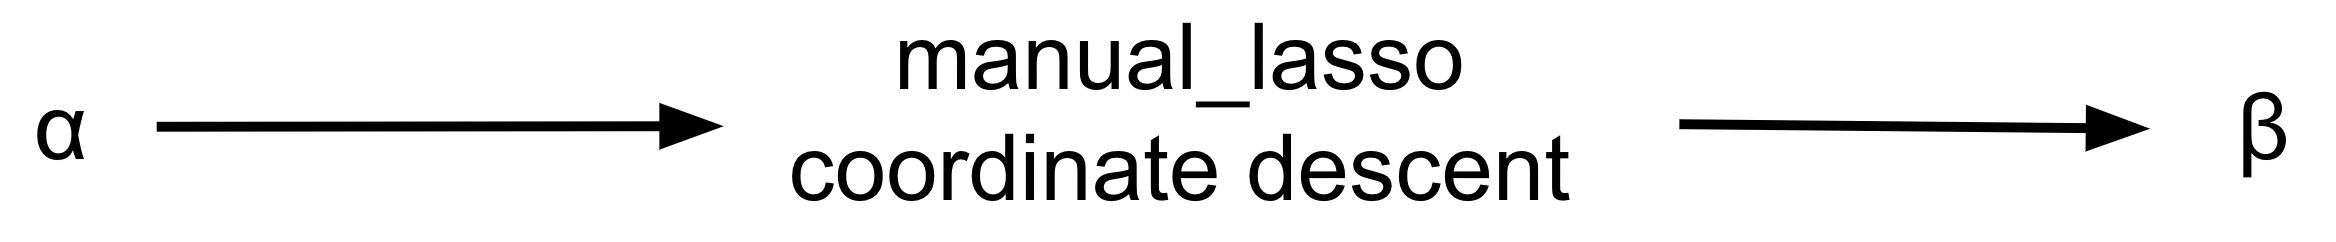

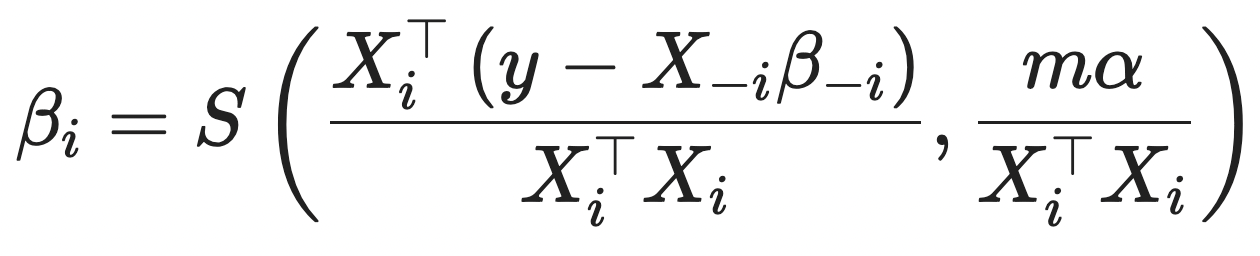

In [8]:
# we implemented a solver class for the Lasso optomization problem，for which the cost function is shown in the equation here.
# we can specify the alpha used in the solver class
# mathematicians has proved that using coordinate descent, we can find the numerical solution to 
# the Lasso optimization problem. In coordinate descent, we iteratively update one entry of the beta
# array at a time until the beta converges. for the interest of time I won't being going into the details 
# of the mathmatical derivations of it, basically you take the coordinate-wise derivative of the target cost 
# function and update the corresponding beta entry with the solution of setting the derivative to 0
# from IPython.display import display, Math, Latex
# display(Math(r'\beta_{i}=S\left(\frac{X_{i}^{\top}\left(y-X_{-i} \beta_{-i}\right)}{X_{i}^{\top} X_{i}}, \frac{m \alpha}{X_{i}^{\top} X_{i}}\right)'))

In [9]:
# coordinate descent: beta_i^k = argmin f(beta_0^k, beta_1^k, ..., beta_i-1^k, beta_i^k, beta_i+1^k-1, ..., beta_n^k-1)
# where f() = 1/m * || X*beta - y ||_2^2 + alpha * ||beta||_1
# take the derivative: f'() = 2/m * (X_i^T * X_i * beta_i + X_i^T *(X_-i * beta_-i - y)) + alpha * sign(beta_i) = 0
# solve: beta_i = soft_thresholding(X_i^T *(y - X_-i * beta_-i), m * alpha / 2) / ||x_i||_2^2
# https://www.jstatsoft.org/article/view/v033i01/v33i01.pdf
def soft_thresholding(zeta, gamma):
  if zeta > gamma:
      return zeta - gamma
  elif zeta < -gamma:
      return zeta + gamma
  else:
      return 0

def cost_func(X, y, Beta, Alpha):
  (m, n) = X.shape
  (num_coordinates, ) = Beta.shape
  term1 = np.dot(X, Beta) - y
  return np.inner(term1, term1) / (2*m) + Alpha * np.linalg.norm(Beta, ord=1)

class manual_lasso():
  def __init__(self, alpha):
    self.alpha = alpha
    self.cost = []
  
  # implementing the coordinate descent algorithm to find the optimum coefficients
  def fit(self, X, y):
    (m, n) = X.shape
    X = np.c_[ X, np.ones(m) ]
    (m, n) = X.shape
    Beta = np.zeros(n)
    iteration = 1000
    previous_beta = np.copy(Beta)
    for _ in range(iteration):
      for i in range(n):
        this_cost = cost_func(X, y, Beta, self.alpha)
        self.cost.append(this_cost)
        X_i = X[:, i] # i_th column of X
        X_minus_i = np.delete(X, i, 1) # delete the i_th column of X
        beta_minus_i = np.delete(Beta, i, 0)
        X_i_T = np.transpose(X_i)
        # iteratively update one entry of the beta array at a time
        Beta[i] = np.dot(X_i_T, (y - np.dot(X_minus_i, beta_minus_i))) / np.inner(X_i, X_i) if (i == n - 1) else soft_thresholding(np.dot(X_i_T, (y - np.dot(X_minus_i, beta_minus_i))), m * self.alpha) / np.inner(X_i, X_i)
      if(np.allclose(Beta, previous_beta)):
        break
      previous_beta = np.copy(Beta)
    self.beta = Beta[:-1]
    self.intercept = Beta[-1]
    return self

  def predict(self, X):
    return np.dot(X, self.beta) + self.intercept

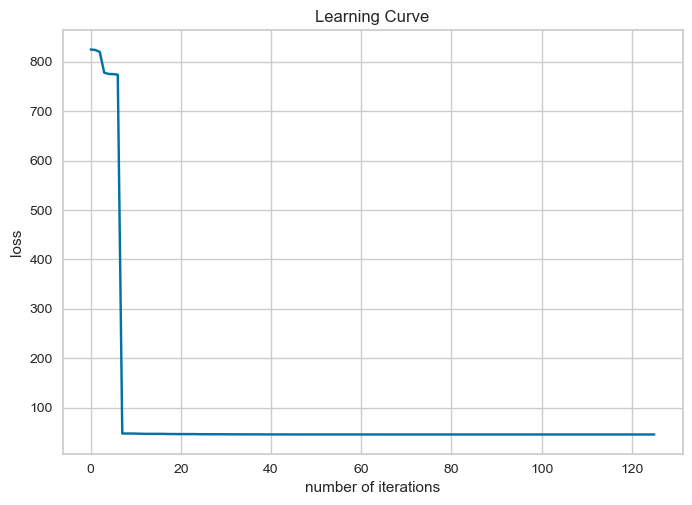

In [10]:
# plot a learing curve example using the training data and alpha = 0.1
model = manual_lasso(alpha=0.1)
model.fit(train_std, y_train_array)
plt.plot(model.cost)
plt.title('Learning Curve')
plt.xlabel('number of iterations')
plt.ylabel('loss')
plt.show()

In [11]:
real_estate

No  X1 transaction date  X2 house age  \
316  317             2013.250          13.3   
259  260             2013.083          17.7   
103  104             2012.750           0.0   
48    49             2013.417          24.2   
360  361             2012.667          32.9   
..   ...                  ...           ...   
323  324             2013.417          28.6   
159  160             2012.667          15.5   
114  115             2012.667          30.6   
157  158             2013.250          16.1   
347  348             2013.583          17.4   

     X3 distance to the nearest MRT station  X4 number of convenience stores  \
316                               250.63100                                7   
259                               837.72330                                0   
103                               208.39050                                6   
48                               4605.74900                                0   
360                                87.30222                               10   
..                                      ...                              ...   
323                               197.13380                                6   
159                               815.93140                                4   
114                               143.83830                                8   
157                               815.93140                                4   
347                              6488.02100                                1   

     X5 latitude  X6 longitude  Y house price of unit area  
316     24.96606     121.54297                        42.0  
259     24.96334     121.54767                        28.8  
103     24.95618     121.53844                        45.7  
48      24.94684     121.49578                        13.4  
360     24.98300     121.54022                        47.1  
..           ...           ...                         ...  
323     24.97631     121.54436                        42.5  
159     24.97886     121.53464                        37.4  
114     24.98155     121.54142                        53.3  
157     24.97886     121.53464                        35.6  
347     24.95719     121.47353                        11.2  

[414 rows x 8 columns]

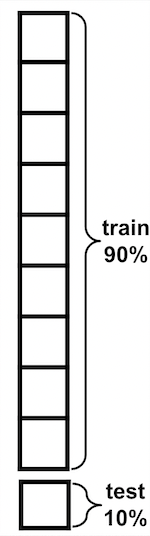

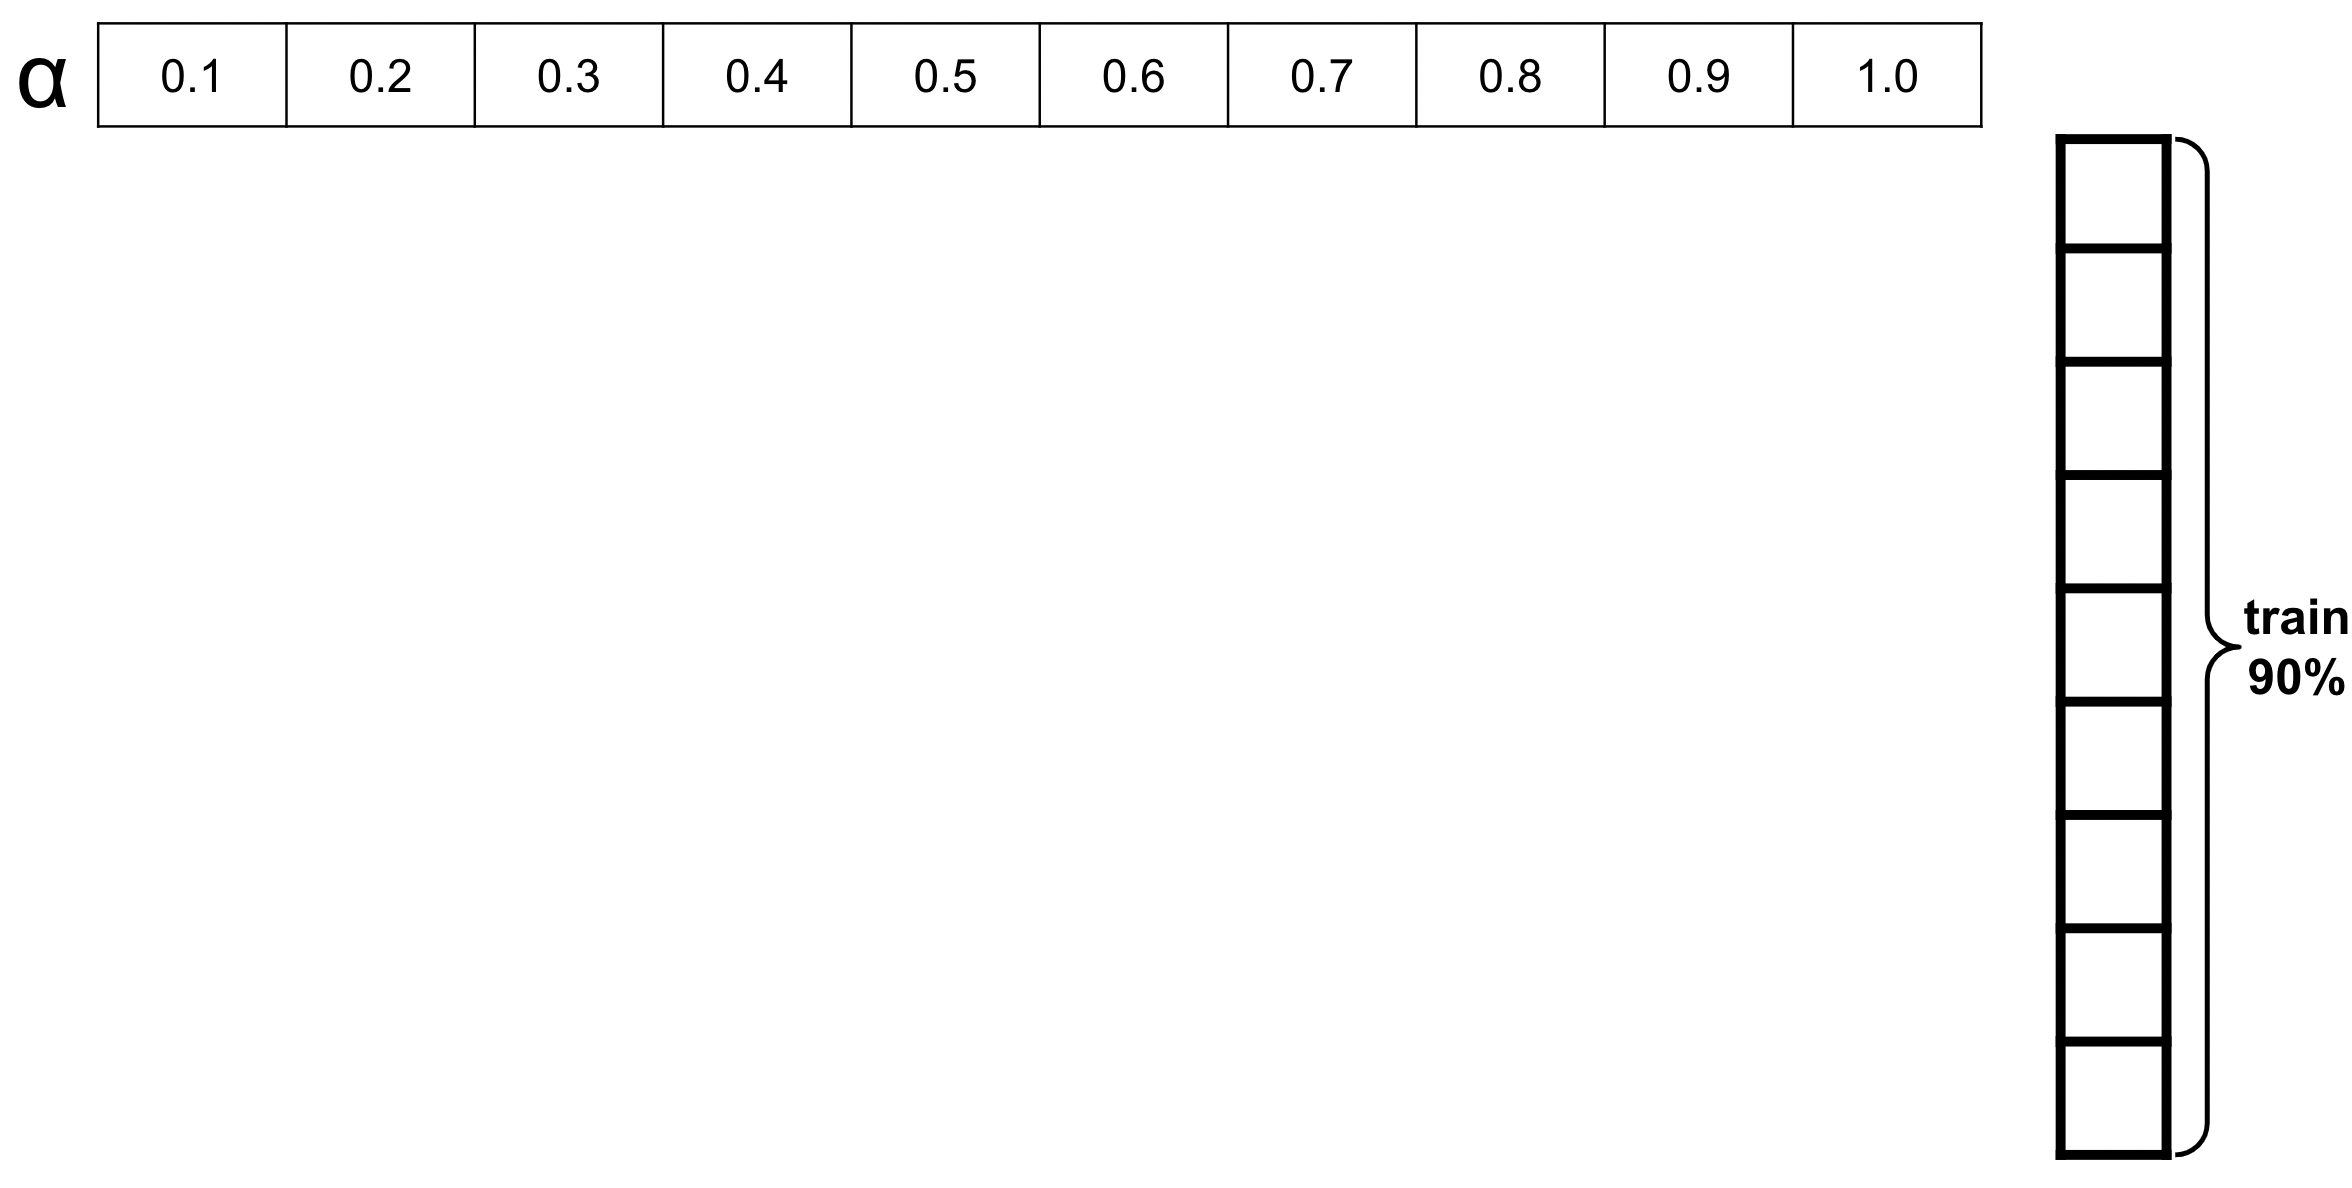

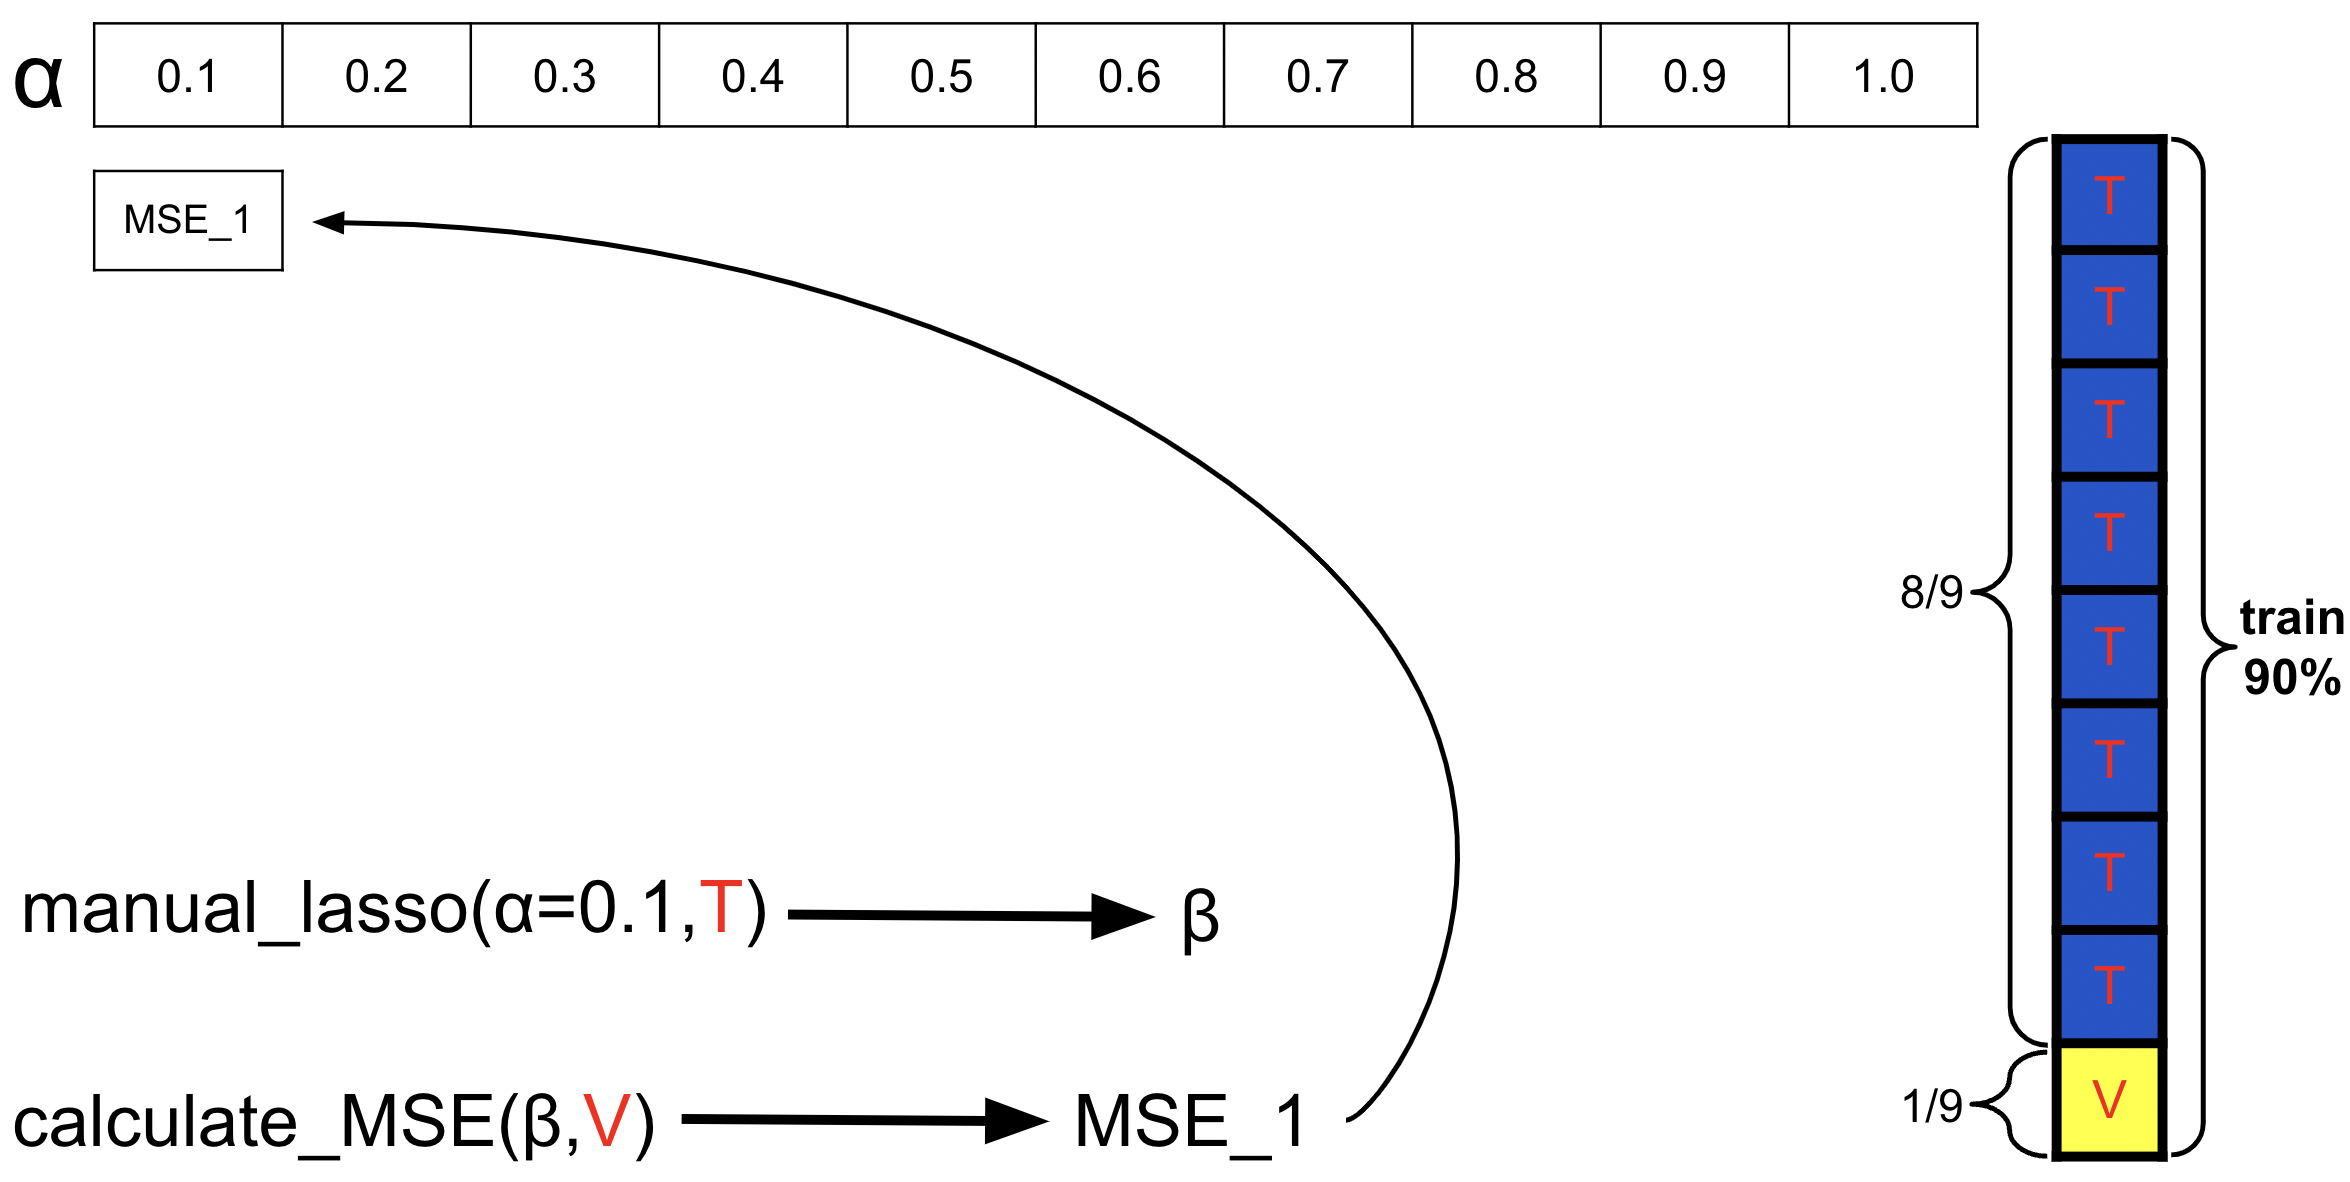

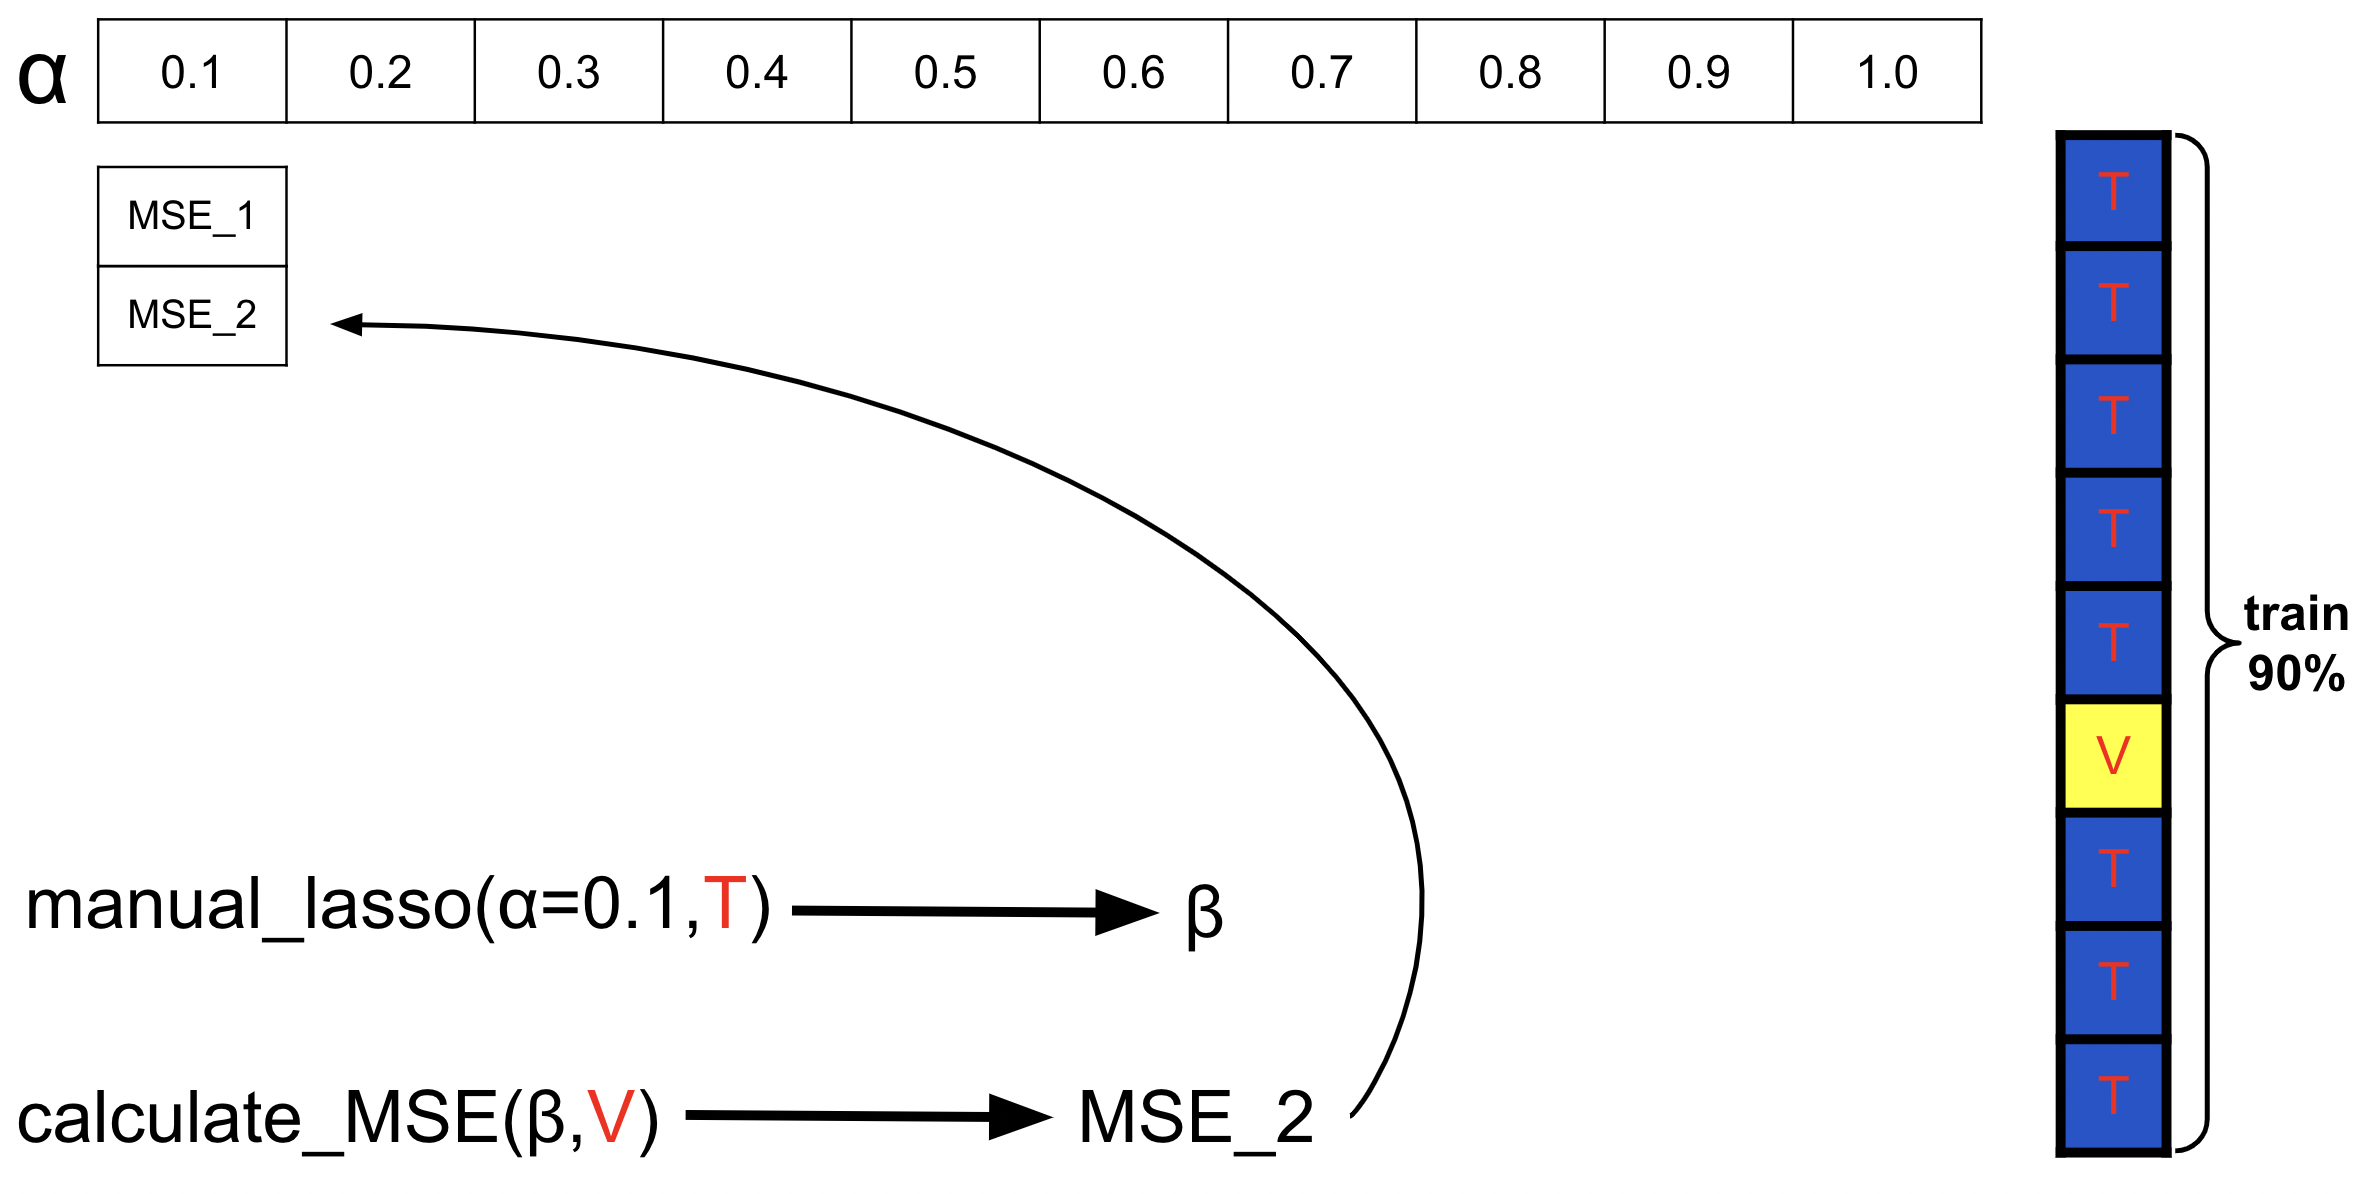

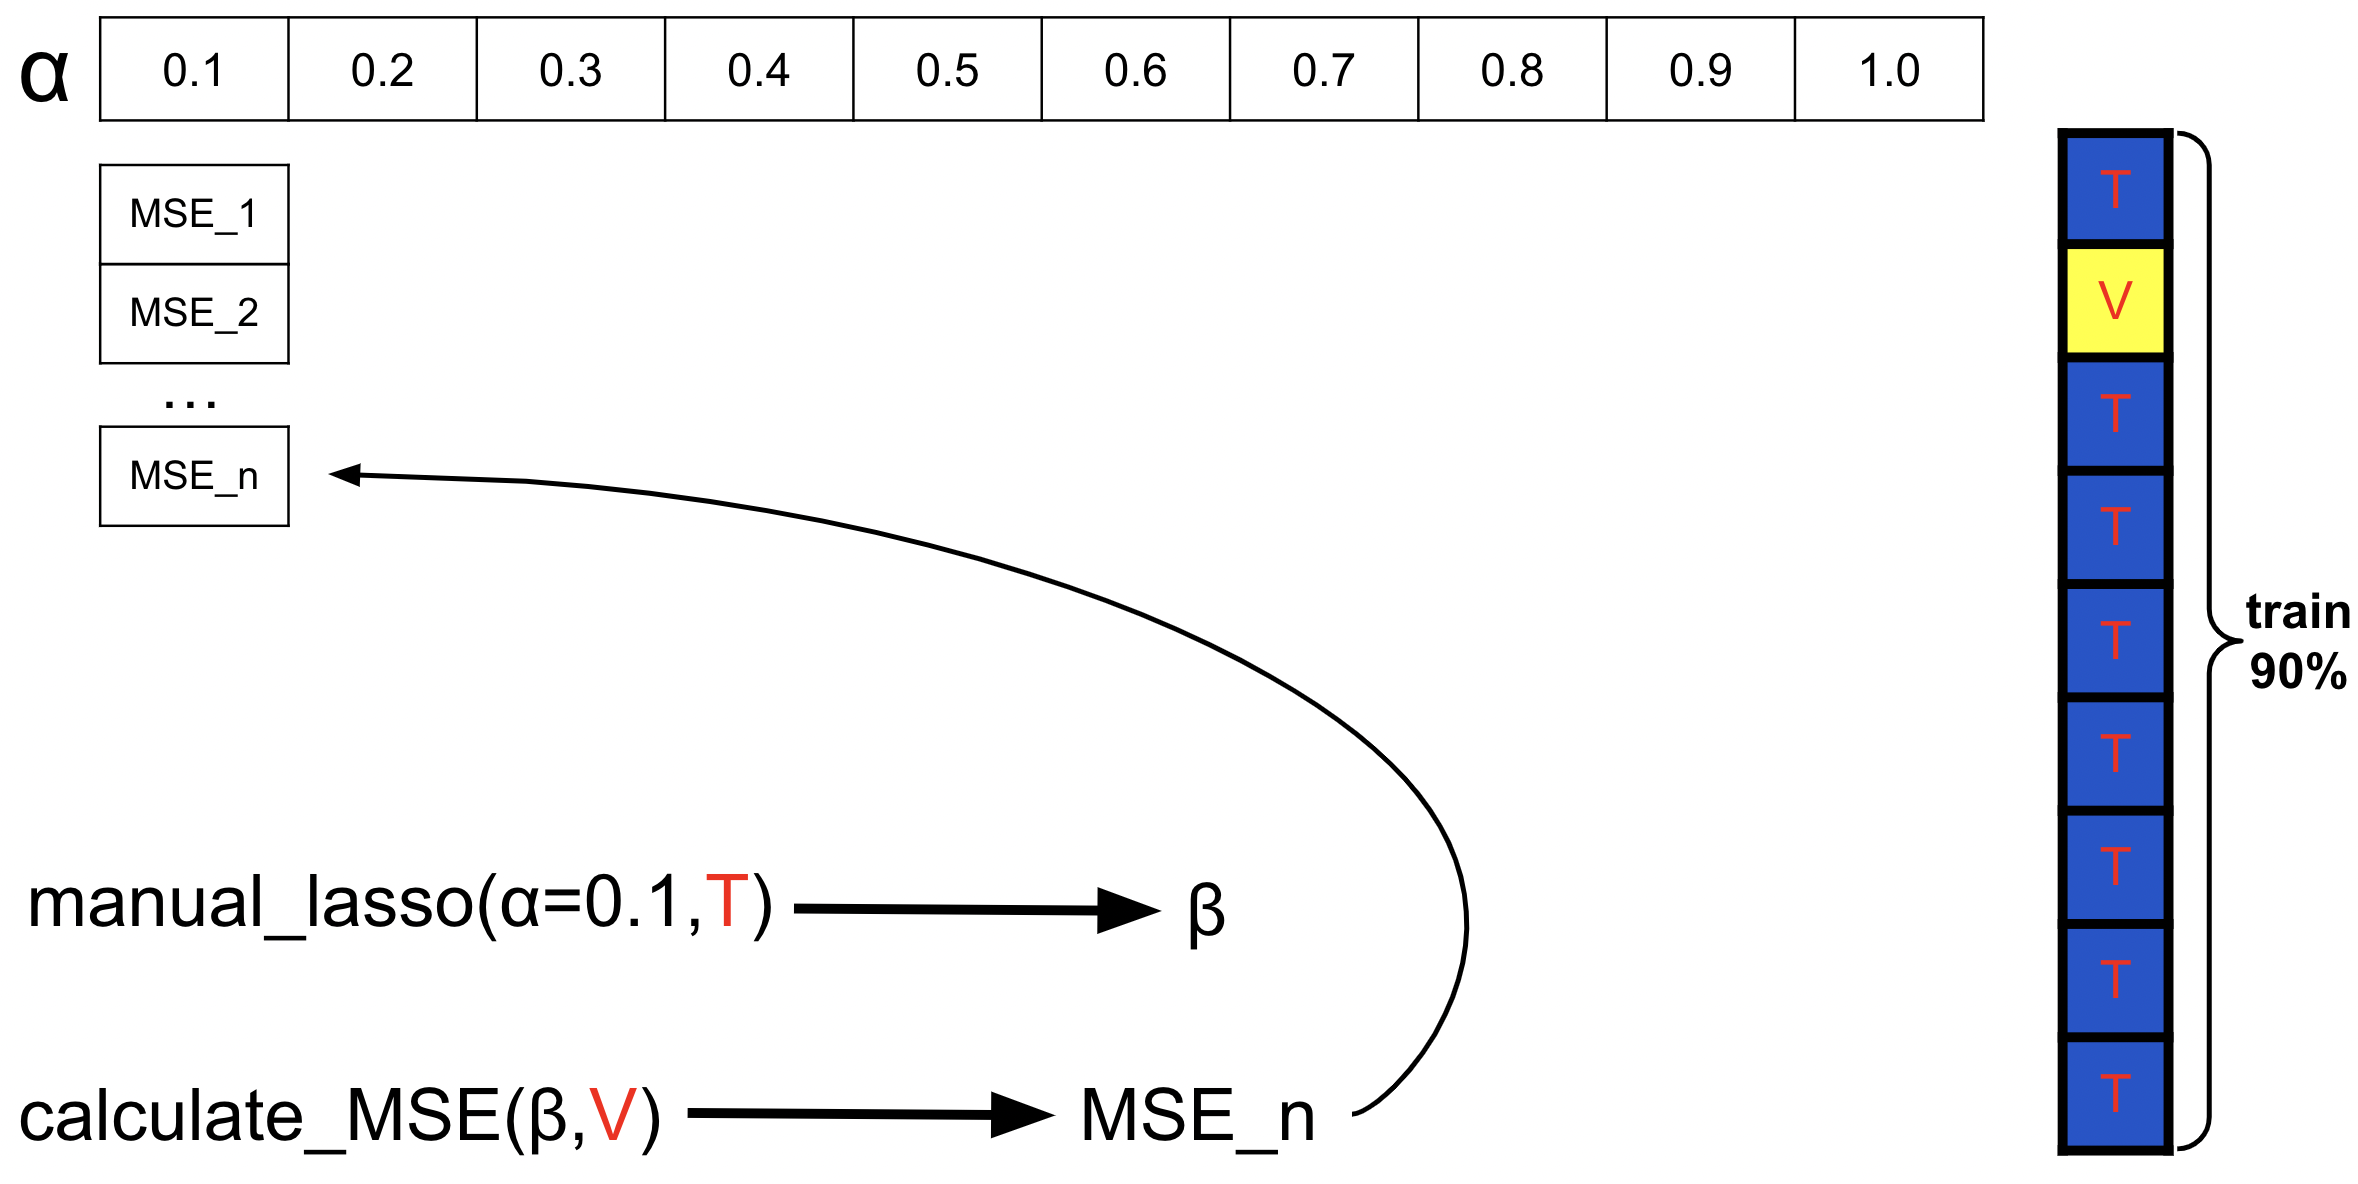

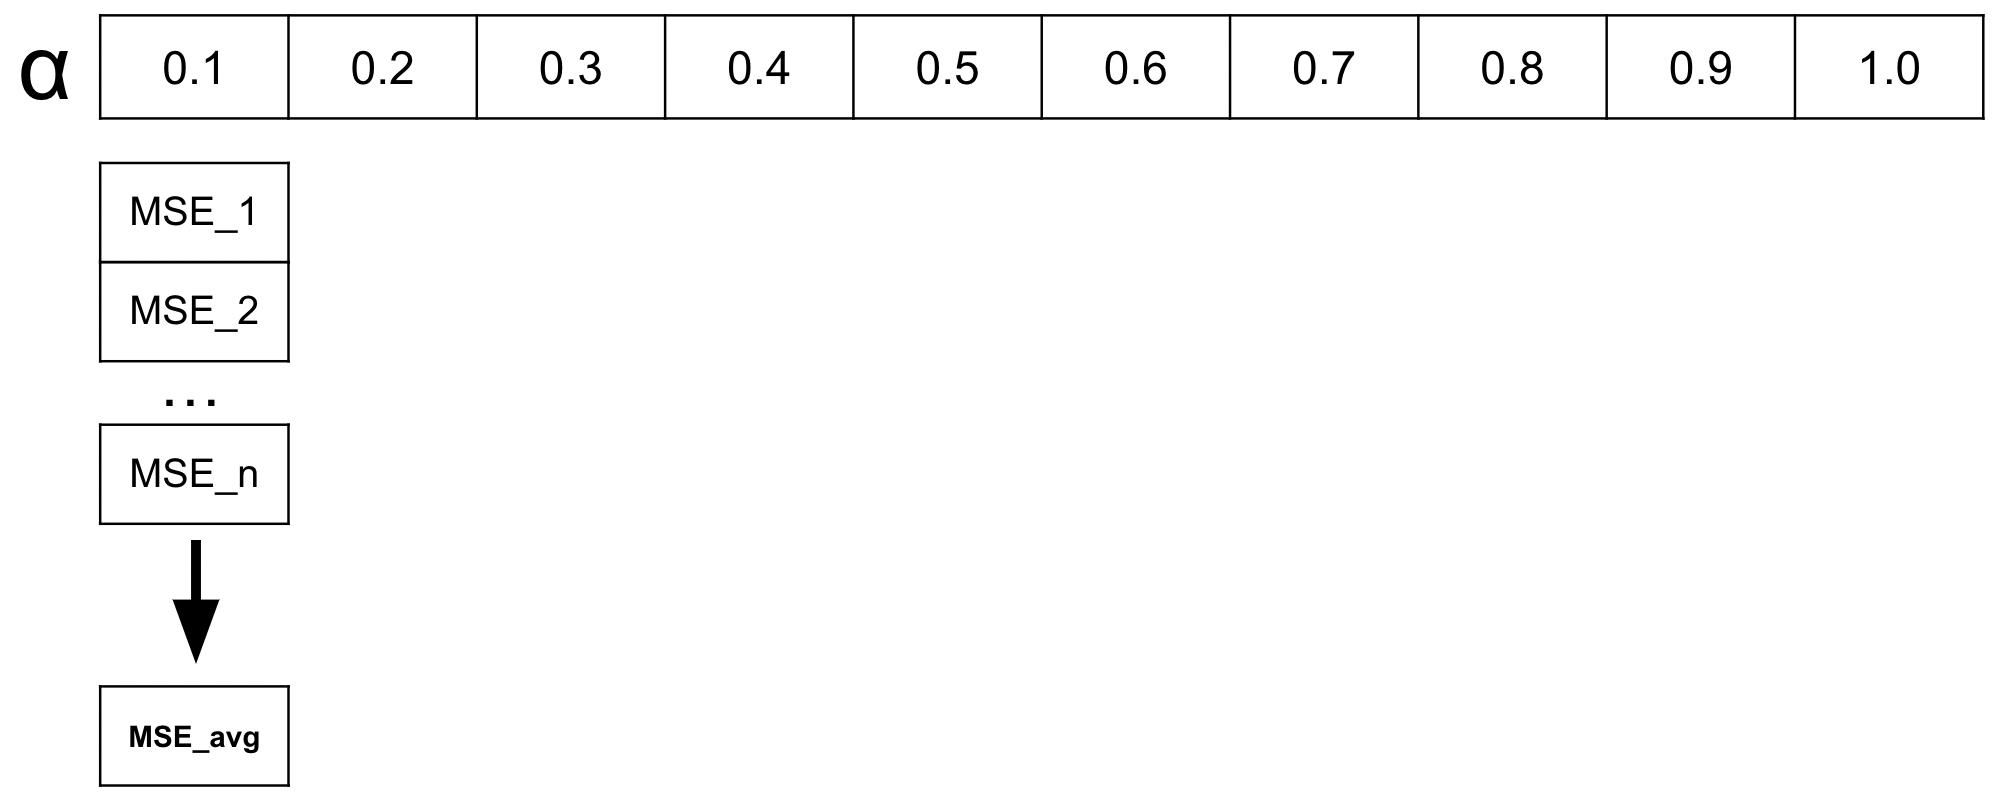

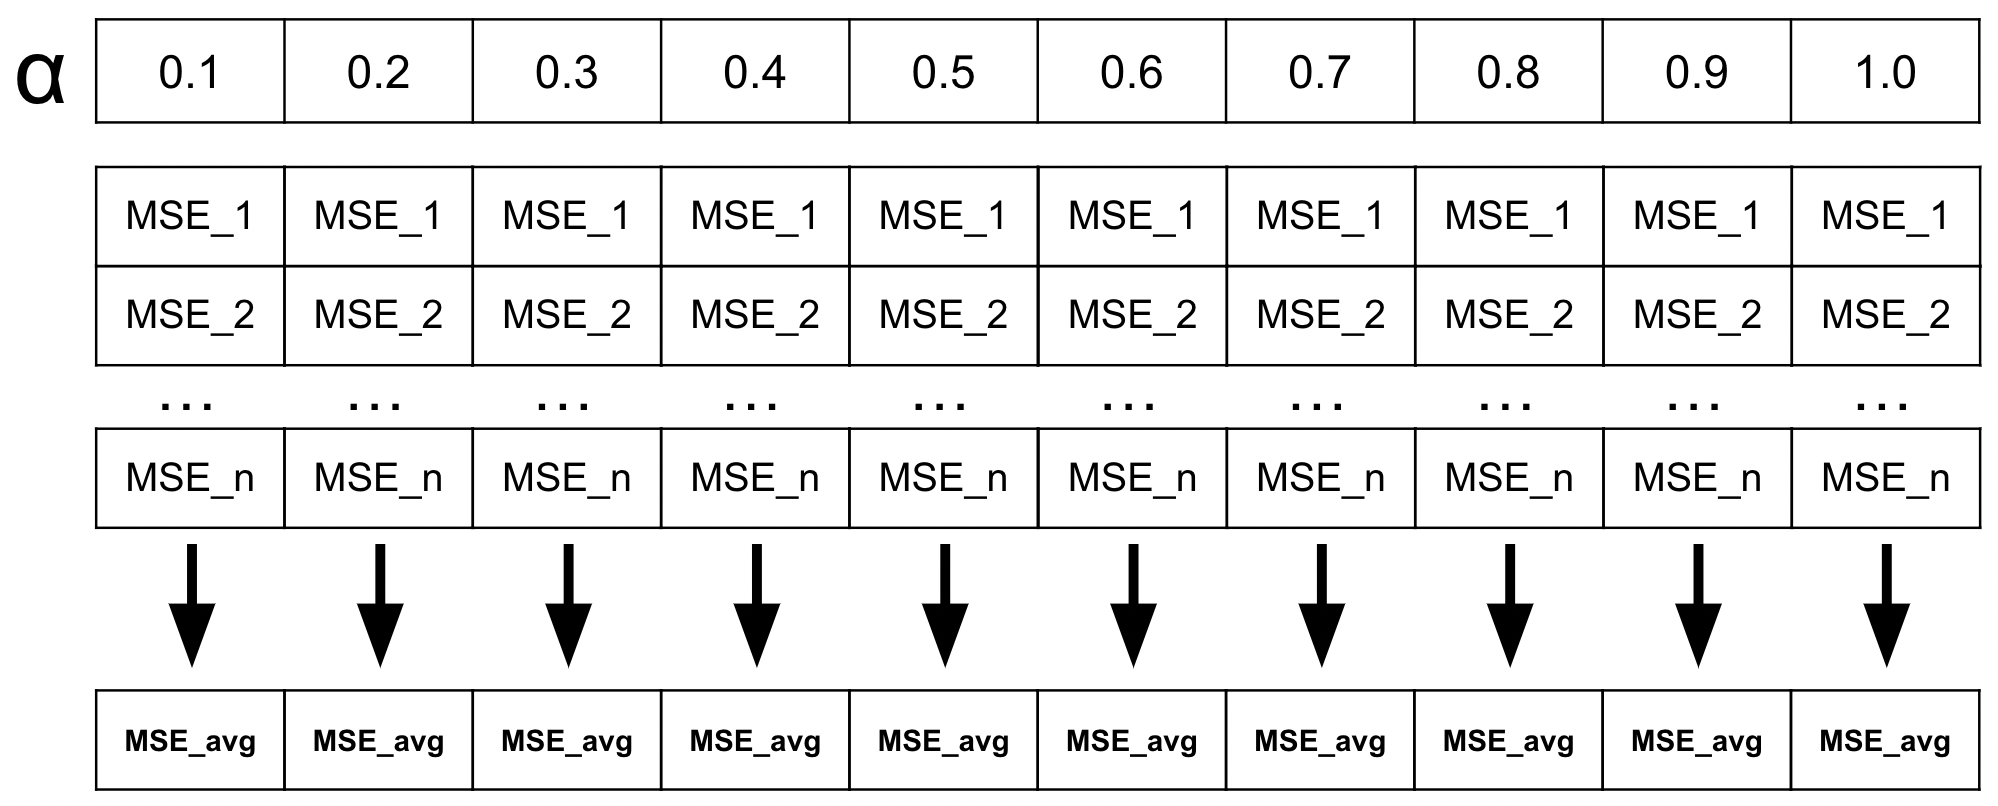

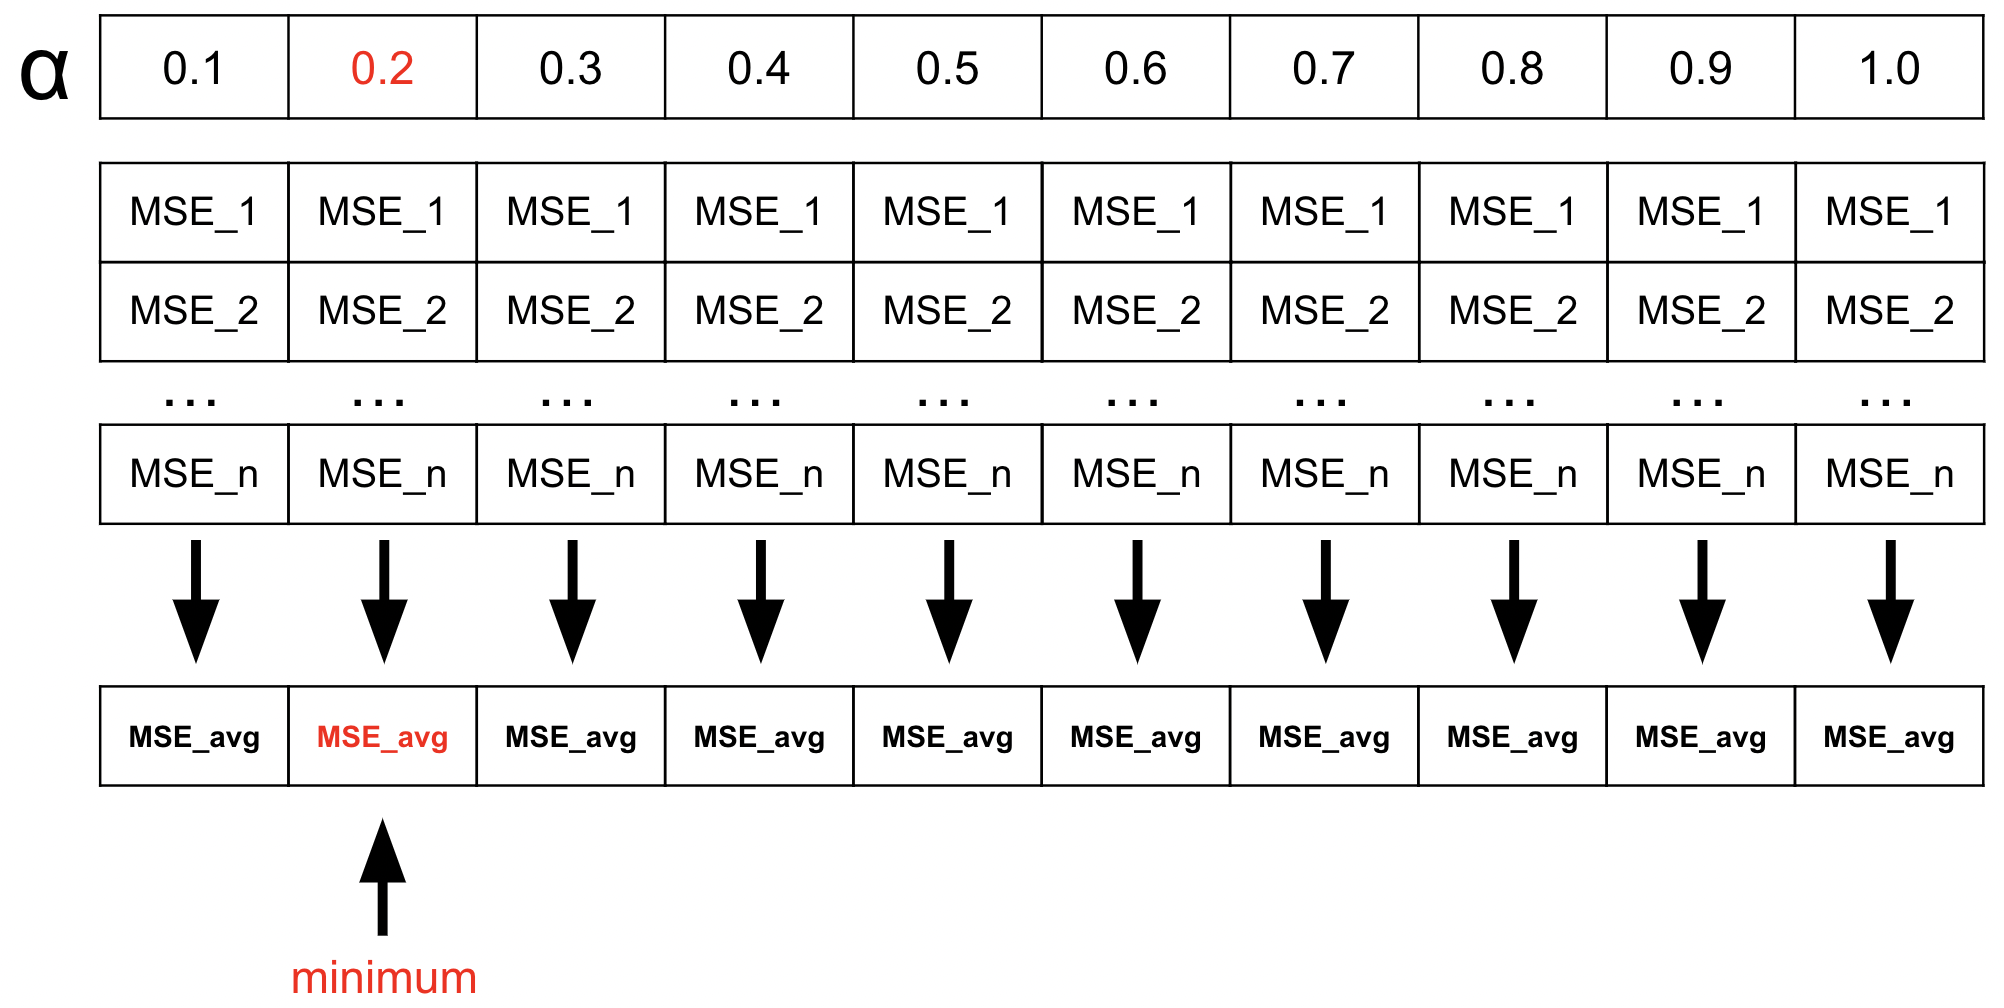

Alpha = 0.165


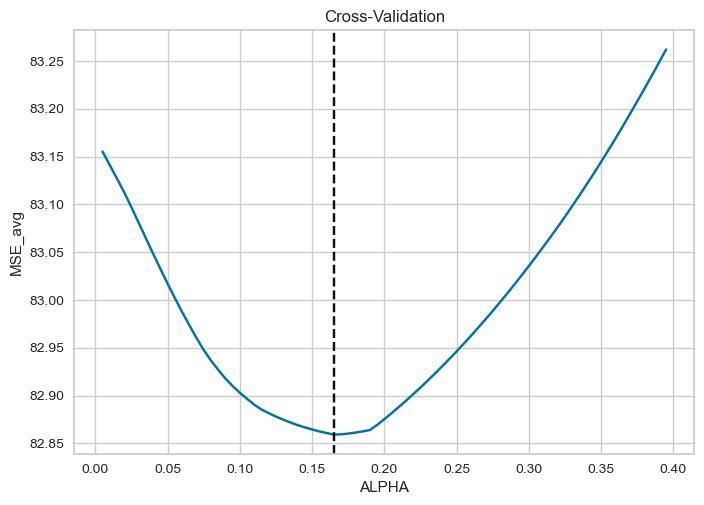

In [12]:
# use the cross-validation and the manual_lasso tunning the alpha the detail show in the picture above
cv = RepeatedKFold(n_splits=9, n_repeats=5, random_state = 1)
mse_path = []
models = []
alphas = np.arange(0.005, 0.4, 0.005)
for alpha in alphas:
  mse_path.append([])
  for folds in list(cv.split(train_std, y_train_array)):
    train_index, test_index = folds
    this_train_x = train_std[train_index,:]
    this_test_x = train_std[test_index,:]
    this_train_y = y_train_array[train_index]
    this_test_y = y_train_array[test_index]

    model = manual_lasso(alpha=alpha)
    model.fit(this_train_x, this_train_y)
    this_predicted_y= model.predict(this_test_x)
    this_mse = mean_squared_error(this_test_y, this_predicted_y)
    mse_path[-1].append(this_mse)
    model.fit(train_std, y_train_array)
    models.append(model)

mse_path = np.array(mse_path)
mean_mse = np.mean(mse_path, axis=-1)
mean_mse.shape
label = "Alpha = "+str(alphas[np.argmin(mean_mse)])
print(label)
plt.plot(alphas, mean_mse, label="lasso")
plt.title('Cross-Validation')
plt.xlabel('ALPHA')
plt.ylabel('MSE_avg')
plt.axvline(alphas[np.argmin(mean_mse)], color="k", linestyle="dashed", label=label)
plt.show()

In [13]:
# testing the optimum model on the testing set
model = manual_lasso(alpha=alphas[np.argmin(mean_mse)])
model.fit(train_std, y_train_array)
predicted_y= model.predict(test_std)
mse_t = mean_squared_error(predicted_y, y_test_array)
rmse_t = np.sqrt(mse_t)
r2_t = r2_score(predicted_y, y_test_array)
mae_t = mean_absolute_error(predicted_y, y_test_array)

pd.DataFrame({'Testing Set':  [r2_t, mse_t, rmse_t, mae_t],
             },
              index=['R2', 'MSE', 'RMSE', 'MAE'])

Testing Set
R2       0.528747
MSE     50.892989
RMSE     7.133932
MAE      5.488252

In [14]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(train_std, y_train_array)
l_predicted_y= clf.predict(test_std)
l_mse_t = mean_squared_error(l_predicted_y, y_test_array)
print(l_mse_t)

51.97627916444576


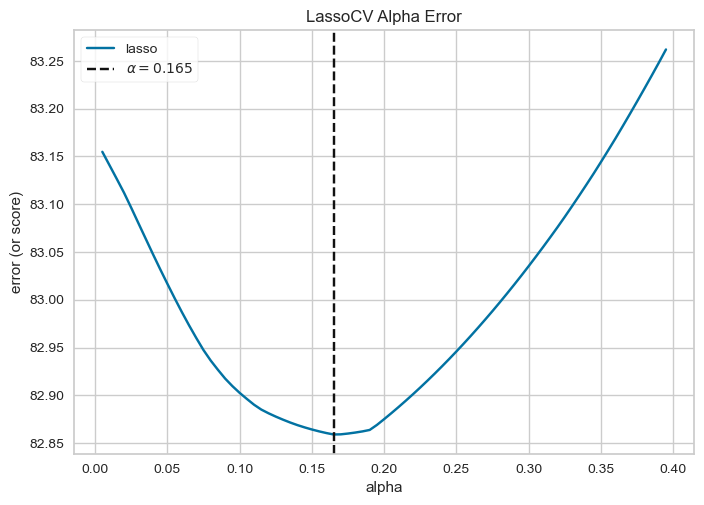

Testing Set
R2       0.528752
MSE     50.892640
RMSE     7.133908
MAE      5.488214

In [15]:
# Create a list of alphas to cross-validate against
alphas = np.arange(0.005,0.4,0.005)

# Instantiate the linear model and visualizer
cv = RepeatedKFold(n_splits=9, n_repeats=5, random_state = 1)
model = LassoCV(alphas=alphas,cv=cv)
visualizer = AlphaSelection(model)
visualizer.fit(train_std, y_train_array)
visualizer.show()

# testing the optimum model on the testing set
predicted_y= model.predict(test_std)
mse_t = mean_squared_error(predicted_y, y_test_array)
rmse_t = np.sqrt(mse_t)
r2_t = r2_score(predicted_y, y_test_array)
mae_t = mean_absolute_error(predicted_y, y_test_array)

pd.DataFrame({'Testing Set':  [r2_t, mse_t, rmse_t, mae_t],
             },
              index=['R2', 'MSE', 'RMSE', 'MAE'])